In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn scipy tqdm

In [3]:
# Cell 1: imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
import scipy.sparse as sp
from tqdm.auto import tqdm

plt.rcParams['figure.figsize'] = (10,5)
sns.set_style('whitegrid')
RANDOM_STATE = 42


In [4]:
# Cell 2: load dataset (adjust path)
file_path = '/mnt/data/electronics.csv'   # change if needed
df = pd.read_csv("electronics.csv", low_memory=False)
print("shape:", df.shape)
df.head()

shape: (1292954, 10)


,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,NaN,1999,NaN,0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,NaN,1999,NaN,0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,NaN,1999,NaN,0
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,NaN,1999,NaN,0
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,NaN,1999,NaN,0


In [5]:
# Cell 3: quick cleaning and timestamp
# Cast types for memory (optional)
df['item_id'] = df['item_id'].astype('int32')
df['user_id'] = df['user_id'].astype('int32')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce').astype('float32')

# Parse timestamp reliably
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
print("parsed timestamps:", df['timestamp'].notna().sum(), "rows")

# Create year/month columns
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['date'] = df['timestamp'].dt.date

# Fill missing categorical fields to avoid grouping problems
df['brand'] = df['brand'].fillna('Unknown')
df['category'] = df['category'].fillna('Unknown')
df['user_attr'] = df['user_attr'].fillna('Unknown')

# Optional: save cleaned csv for quick reload later
df.to_csv('electronics_cleaned.csv', index=False)
print("Saved cleaned sample to electronics_cleaned.csv")


parsed timestamps: 1292954 rows
Saved cleaned sample to electronics_cleaned.csv


Rating value counts:
 rating
1.0    143755
2.0     78648
3.0    100630
4.0    214166
5.0    755755
Name: count, dtype: int64

Rating summary:
 count    1.292954e+06
mean     4.051482e+00
std      1.378048e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


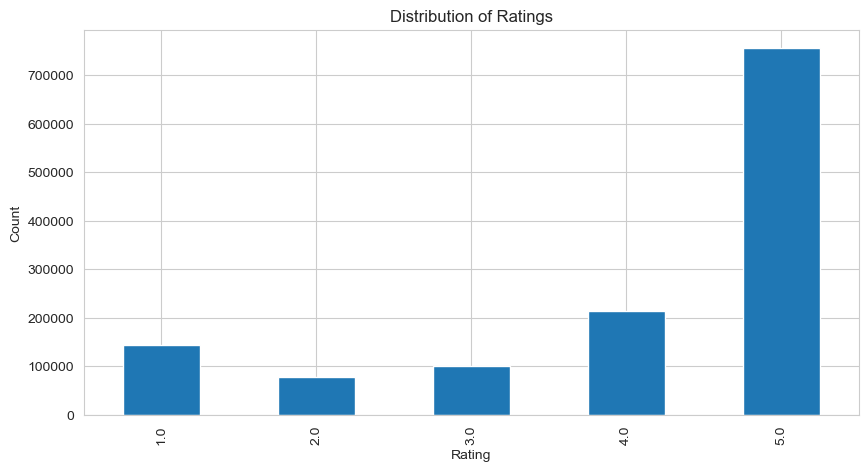

In [6]:
# Cell 4: rating distribution & basic stats
print("Rating value counts:\n", df['rating'].value_counts().sort_index())
print("\nRating summary:\n", df['rating'].describe())

# Plot distribution
plt.figure()
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

,count,mean
category,,
Headphones,359334,3.895877
Computers & Accessories,322938,4.101871
Camera & Photo,192573,4.129795
Accessories & Supplies,158598,4.257784
Portable Audio & Video,143370,4.122996
Car Electronics & GPS,33070,4.062897
Television & Video,32057,3.841626
Home Audio,24193,4.047410
Wearable Technology,16015,3.494224


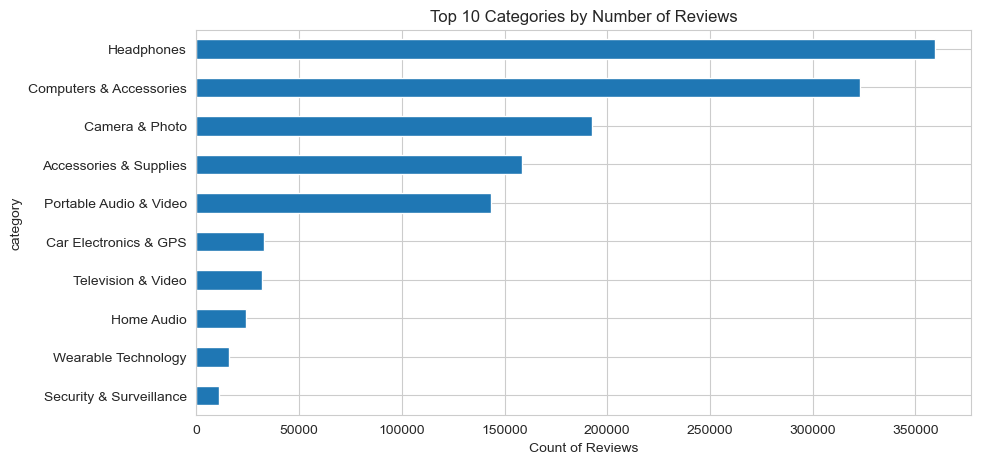

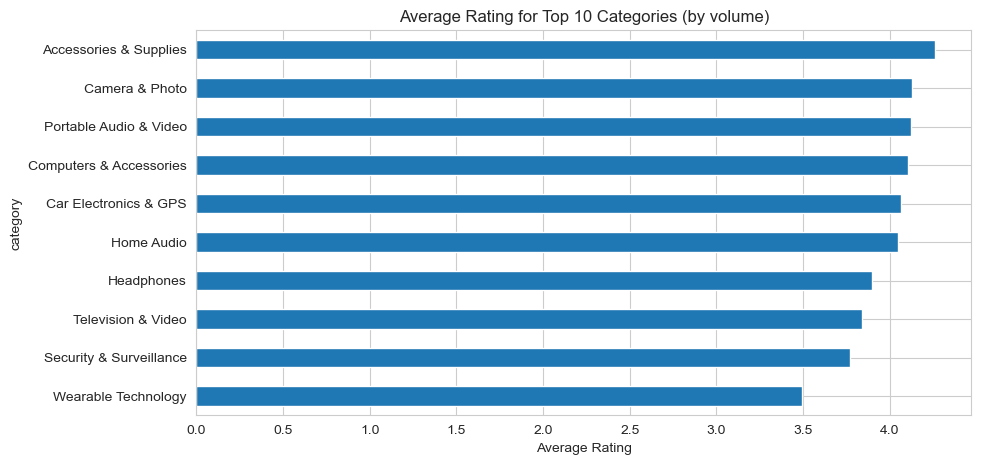

In [7]:
# Cell 5: top categories by review volume and avg rating
cat_stats = df.groupby('category')['rating'].agg(['count','mean']).sort_values('count', ascending=False)
display(cat_stats.head(15))

# Plot top 10 by count
top10 = cat_stats.head(10).sort_values('count')
plt.figure()
top10['count'].plot(kind='barh')
plt.title("Top 10 Categories by Number of Reviews")
plt.xlabel("Count of Reviews")
plt.show()

# Plot average rating for top 10 categories (by volume)
plt.figure()
top10['mean'].sort_values().plot(kind='barh')
plt.title("Average Rating for Top 10 Categories (by volume)")
plt.xlabel("Average Rating")
plt.show()

,brand,count,mean
33,Plemo,2385,4.589098
37,Savage,1749,4.534591
10,Fintie,7212,4.514004
42,Tiamat,1738,4.498274
4,Cooper Cases,745,4.389262
49,ebasy,2771,4.381812
0,Apple,6027,4.374979
11,Fujifilm,12245,4.332544
28,Neewer,6697,4.320143
2,Bose,29222,4.285983


,brand,count,mean
20,Jabra,7417,3.606580
25,Linksys,8288,3.539093
47,Vivitar,774,3.511628
18,JLAB,10079,3.501339
50,iRULU,991,3.474268
15,Generic,1606,3.465131
12,Funlux,939,3.394036
17,IRULU,933,3.369775
1,Archos,961,3.257024
7,EINCAR,616,3.069805


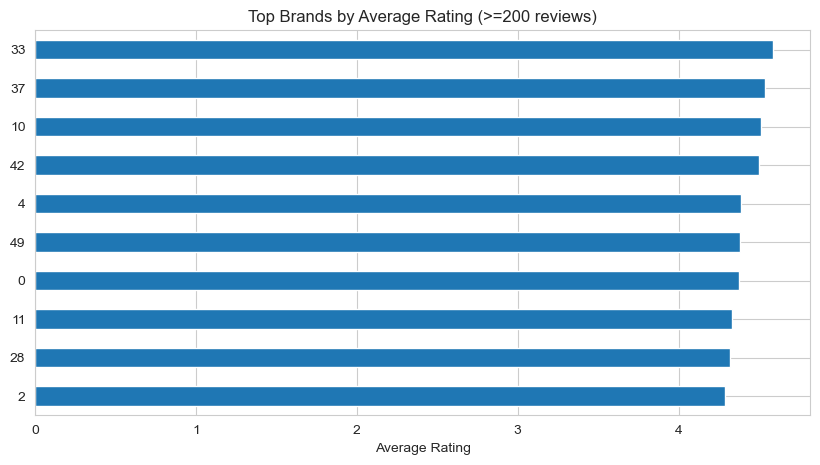

In [8]:
# Cell 6: Brand performance
brand_stats = df.groupby('brand')['rating'].agg(['count','mean']).reset_index()
# Filter to brands with reasonable sample size to avoid noise
brand_stats_filtered = brand_stats[brand_stats['count'] >= 200].sort_values('mean', ascending=False)
display(brand_stats_filtered.head(10))
display(brand_stats_filtered.tail(10))

# Visual: top 10 brands by avg rating (>=200 reviews)
plt.figure()
brand_stats_filtered.head(10).sort_values('mean')['mean'].plot(kind='barh')
plt.title("Top Brands by Average Rating (>=200 reviews)")
plt.xlabel("Average Rating")
plt.show()

In [9]:
# Cell 7: item-level stats (use threshold to avoid noisy items)
item_stats = df.groupby('item_id')['rating'].agg(['count','mean']).reset_index()
min_reviews = 50   # increase for more robust results
popular_items = item_stats[item_stats['count'] >= min_reviews].sort_values('mean', ascending=False)
popular_items.head(10)

# To show human-friendly info, merge category/brand for that item
item_info = df[['item_id','brand','category']].drop_duplicates(subset=['item_id']).set_index('item_id')
top_items = popular_items.head(20).join(item_info, on='item_id')
top_items[['count','mean','brand','category']]

,count,mean,brand,category
2513,135,5.000000,Unknown,Camera & Photo
1647,185,4.994595,Unknown,Portable Audio & Video
4659,93,4.956989,Unknown,Car Electronics & GPS
8946,50,4.940000,Unknown,Computers & Accessories
8484,90,4.911111,Canon,Camera & Photo
1512,50,4.900000,Nikon,Camera & Photo
4966,60,4.900000,Plemo,Computers & Accessories
4050,96,4.895833,Unknown,Computers & Accessories
3103,62,4.887097,Unknown,Accessories & Supplies
7570,93,4.881721,Unknown,Accessories & Supplies


,count,mean
year,,
1999,47,3.744681
2000,187,3.877005
2001,403,4.114144
2002,481,4.012474
2003,833,3.806723
2004,1275,3.840784
2005,2170,3.877419
2006,2614,3.799541
2007,6798,4.055752


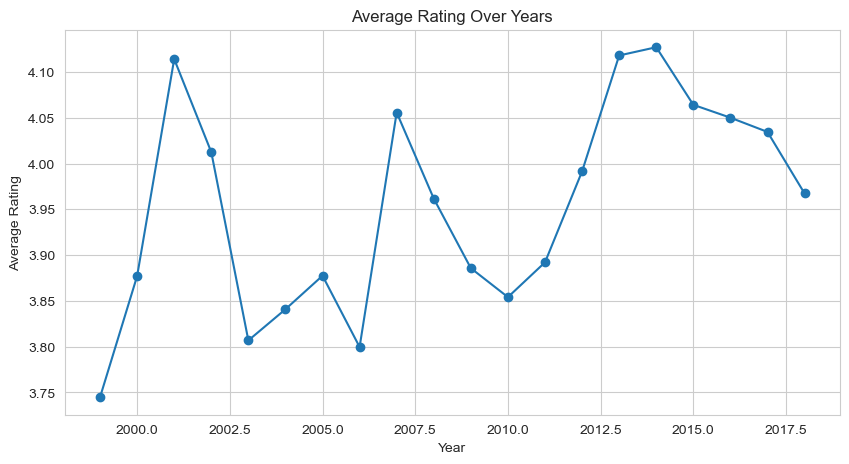

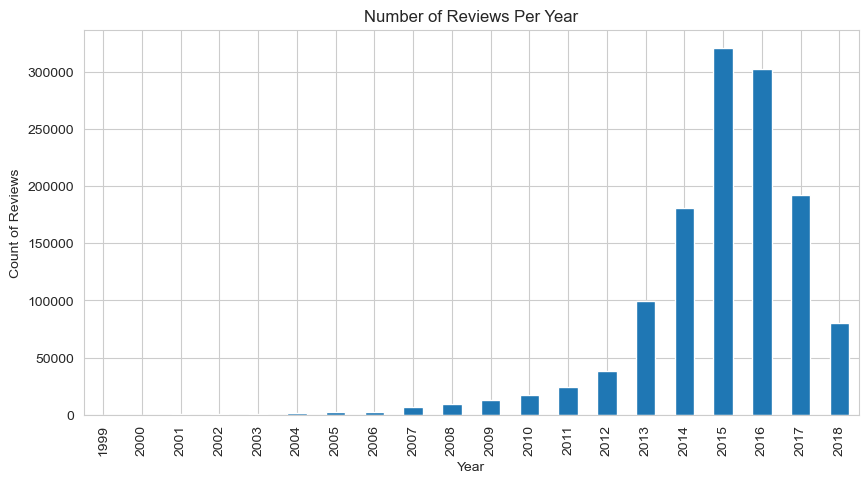

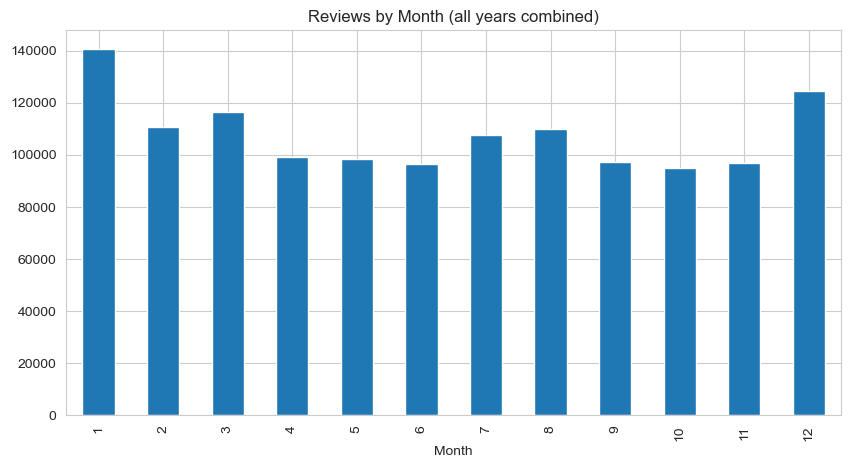

In [10]:
# Cell 8: yearly and monthly trend analysis
yearly = df.groupby('year')['rating'].agg(['count','mean']).dropna().sort_index()
display(yearly)

# plot avg rating over years
plt.figure()
yearly['mean'].plot(marker='o')
plt.title("Average Rating Over Years")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()

# plot review count per year
plt.figure()
yearly['count'].plot(kind='bar')
plt.title("Number of Reviews Per Year")
plt.xlabel("Year")
plt.ylabel("Count of Reviews")
plt.show()

# monthly (across all years) - can help seasonality
monthly = df.groupby('month')['rating'].agg(['count','mean']).sort_index()
plt.figure()
monthly['count'].plot(kind='bar')
plt.title("Reviews by Month (all years combined)")
plt.xlabel("Month")
plt.show()

In [12]:
# Aggregate user-level features again
user_agg = df.groupby('user_id').agg(
    n_reviews = ('rating','count'),
    avg_rating = ('rating','mean'),
    std_rating = ('rating','std'),
    first_year = ('year','min'),
    last_year = ('year','max')
).reset_index()

# Add derived features
user_agg['active_years'] = user_agg['last_year'] - user_agg['first_year'] + 1
user_agg['std_rating'] = user_agg['std_rating'].fillna(0)

print("user_agg shape:", user_agg.shape)
user_agg.head()


user_agg shape: (1157633, 7)


,user_id,n_reviews,avg_rating,std_rating,first_year,last_year,active_years
0,0,1,5.0,0.0,1999,1999,1
1,1,1,5.0,0.0,1999,1999,1
2,2,1,3.0,0.0,1999,1999,1
3,3,1,1.0,0.0,1999,1999,1
4,4,1,2.0,0.0,1999,1999,1


In [13]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np

# 1. Take a sample of 100k users
user_sample = user_agg.sample(n=100000, random_state=RANDOM_STATE)

# 2. Features for clustering
features = user_sample[['n_reviews','avg_rating','std_rating','active_years']].copy()
features['n_reviews_log'] = np.log1p(features['n_reviews'])
X = features[['n_reviews_log','avg_rating','std_rating','active_years']].values

# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. MiniBatchKMeans (faster than standard KMeans)
sil_scores = {}
for k in range(2,7):
    km = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, batch_size=1000)
    labs = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labs, sample_size=10000)  # use subset for silhouette calc
    sil_scores[k] = sil

sil_scores

C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a mem

{2: 0.777808830744925,
 3: 0.7081959005018501,
 4: 0.7277181389622652,
 5: 0.7421166730550516,
 6: 0.8247113465012222}

In [15]:
# Final clustering with k=6
best_k = 6
km = MiniBatchKMeans(n_clusters=best_k, random_state=RANDOM_STATE, batch_size=2048, n_init=10)
user_sample['cluster'] = km.fit_predict(X_scaled)

# Describe clusters
cluster_summary = user_sample.groupby('cluster').agg(
    n_users=('user_id','count'),
    avg_reviews=('n_reviews','mean'),
    avg_rating=('avg_rating','mean'),
    rating_variability=('std_rating','mean'),
    avg_active_years=('active_years','mean')
).reset_index()

cluster_summary


,cluster,n_users,avg_reviews,avg_rating,rating_variability,avg_active_years
0,0,23501,1.002851,1.828092,0.000000,1.000000
1,1,14699,1.000000,4.000000,0.000000,1.000000
2,2,1846,2.199350,3.268448,2.039434,1.878115
3,3,2155,2.758701,4.127462,0.729481,4.885383
4,4,4895,2.187334,4.552987,0.219874,1.566701
5,5,52904,1.000000,5.000000,0.000000,1.000000


In [16]:
# Cell 10: recommendation using TruncatedSVD on a filtered matrix
# Filter to most active users and most reviewed items
top_item_count = 5000    # adjust by your memory
top_user_count = 20000   # adjust by your memory

top_items = df['item_id'].value_counts().head(top_item_count).index
top_users = df['user_id'].value_counts().head(top_user_count).index

subset = df[df['item_id'].isin(top_items) & df['user_id'].isin(top_users)].copy()
print("subset shape:", subset.shape)

# create mappings
unique_users = subset['user_id'].unique()
unique_items = subset['item_id'].unique()
user_map = {u:i for i,u in enumerate(unique_users)}
item_map = {i:j for j,i in enumerate(unique_items)}

rows = subset['user_id'].map(user_map).values
cols = subset['item_id'].map(item_map).values
data = subset['rating'].values

# build sparse user-item matrix
R = sp.csr_matrix((data,(rows,cols)), shape=(len(unique_users), len(unique_items)))
print("Matrix shape:", R.shape)

# Optionally center by user mean (helps SVD)
user_means = np.array(R.mean(axis=1)).squeeze()
# subtract user means explicitly only for non-zero entries is tricky; for simplicity we use raw matrix with SVD

# Truncated SVD
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)
U = svd.fit_transform(R)         # user factors (n_users x k)
Vt = svd.components_             # k x n_items

# function to recommend for a user_id
def recommend_for_user(user_id, top_n=10):
    if user_id not in user_map:
        return []
    u_idx = user_map[user_id]
    u_vec = U[u_idx,:]         # length k
    scores = u_vec.dot(Vt)     # predicted scores for all items
    # zero out items the user has already rated
    rated_mask = R[u_idx,:].toarray().squeeze() > 0
    scores[rated_mask] = -np.inf
    top_idx = np.argpartition(-scores, range(top_n))[:top_n]
    top_idx_sorted = top_idx[np.argsort(-scores[top_idx])]
    rec_item_ids = [unique_items[i] for i in top_idx_sorted]
    return rec_item_ids

# Example: pick a user and get recs
example_user = unique_users[0]
print("Recommendations for user", example_user, ":", recommend_for_user(example_user, top_n=10))


subset shape: (69023, 12)
Matrix shape: (19985, 4574)
Recommendations for user 7 : [1670, 2935, 3401, 2148, 4181, 557, 1780, 2398, 1867, 7022]


In [18]:
import os

# make sure the folder exists
os.makedirs("plots", exist_ok=True)

# now save inside "plots" in your project folder
plt.savefig("plots/rating_distribution.png", bbox_inches="tight")

<Figure size 1000x500 with 0 Axes>

In [21]:
# Add log-transformed reviews column to user_sample
user_sample['n_reviews_log'] = np.log1p(user_sample['n_reviews'])


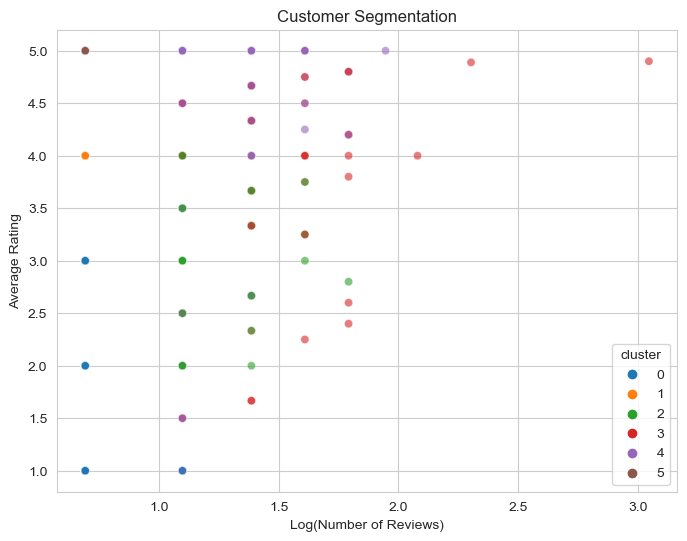

In [22]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=user_sample.sample(5000, random_state=RANDOM_STATE),
    x="n_reviews_log",
    y="avg_rating",
    hue="cluster",
    palette="tab10",
    alpha=0.6
)
plt.title("Customer Segmentation")
plt.xlabel("Log(Number of Reviews)")
plt.ylabel("Average Rating")
plt.show()


In [23]:
# Save cluster stats
os.makedirs("results", exist_ok=True)
cluster_summary.to_csv("results/cluster_summary.csv", index=False)

# Save user assignments (optional, sample only)
user_sample[['user_id','cluster','n_reviews','avg_rating','active_years']].to_csv("results/user_clusters.csv", index=False)

# Amazon Electronics Sales Analysis — Executive Summary

**Dataset:** ~1.29M ratings for Amazon Electronics products (columns: item_id, user_id, rating, timestamp, model_attr, category, brand, year, user_attr).

**Key findings (examples you will fill after running):**
- Top categories by review volume: Headphones, Computers & Accessories, Camera & Photo...
- Categories with highest average ratings: [list after analysis]
- Brands with strong / weak average ratings (>=200 reviews): [list]
- Rating trend over years: average rating peaked in YEAR and declined/increased since...
- Customer segments: identified X clusters (power reviewers, frequent positive reviewers, infrequent reviewers)
- Simple recommender: SVD-based recommender built on top-N active users & items.

**Next steps / business recommendations:**
- Focus product quality improvements on categories with high volume but low average rating.
- Use cluster segments for tailored email campaigns (e.g., reward power reviewers).
- Deploy a full recommender in production (use implicit feedback or hybrid models).

In [27]:
!pip freeze > requirements.txt

In [29]:
!git init
!git add .
!git commit -m "Initial Amazon Electronics Analysis notebook and plots"
# create remote repo on GitHub, then:
!git remote add origin git@github.com:ak251103/amazon-electronics-analysis.git
!git push -u origin main

Initialized empty Git repository in C:/Users/KIIT/Amazon Electronics Sales Analysis/.git/


[master (root-commit) fa80b76] Initial Amazon Electronics Analysis notebook and plots
 8 files changed, 2688071 insertions(+)
 create mode 100644 .ipynb_checkpoints/Amazon_Electronics_Analysis-checkpoint.ipynb
 create mode 100644 Amazon_Electronics_Analysis.ipynb
 create mode 100644 electronics.csv
 create mode 100644 electronics_cleaned.csv
 create mode 100644 plots/rating_distribution.png
 create mode 100644 requirements.txt
 create mode 100644 results/cluster_summary.csv
 create mode 100644 results/user_clusters.csv


error: src refspec main does not match any
error: failed to push some refs to 'github.com:ak251103/amazon-electronics-analysis.git'


In [30]:
!git push -u origin master

Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [33]:
!git remote set-url origin https://github.com/ak251103/amazon-electronics-analysis.git

In [34]:
!git push -u origin master

remote: warning: File electronics.csv is 79.38 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB        
remote: error: Trace: c1beeac049c108d897a466dd60031a730050f40b610fdd5a8a3734e1eb0f19f7        
remote: error: See https://gh.io/lfs for more information.        
remote: error: File electronics_cleaned.csv is 109.60 MB; this exceeds GitHub's file size limit of 100.00 MB        
remote: error: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.        
To https://github.com/ak251103/amazon-electronics-analysis.git
 ! [remote rejected] master -> master (pre-receive hook declined)
error: failed to push some refs to 'https://github.com/ak251103/amazon-electronics-analysis.git'


In [35]:
!git lfs install

Updated Git hooks.
Git LFS initialized.


In [36]:
!git add electronics.csv electronics_cleaned.csv
!git commit -m "Re-commit large files with Git LFS"

On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Amazon_Electronics_Analysis.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git lfs migrate import --include="electronics.csv,electronics_cleaned.csv"

In [ ]:
import shutil

# Use the full Windows path with double backslashes
folder_path = r"C:\Users\KIIT\Amazon Electronics Sales Analysis"

# Create the zip in the same location
shutil.make_archive("Amazon_Electronics_Sales_Analysis", 'zip', folder_path)

